In [1]:
#| include: false
import pandas as pd
import numpy as np
import pickle

import re

import itables

import warnings
warnings.filterwarnings("ignore")

import csv

import dash
from dash import dcc, html
from dash.dependencies import Input, Output

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots 
from ipywidgets import interact, widgets
import plotly.offline as pyo
import plotly.io as pio

import geopandas as gpd
import shapely.geometry as sg
from shapely.geometry import MultiPolygon, Polygon
from shapely import wkt

import folium
from folium.plugins import DualMap, HeatMap

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="plotly")

from dbfread import DBF

In [2]:
#| include: false
# Year 2001
ethnicity_2001= pd.read_csv('preprocessed files/2001/ethnicity_2001.csv')
country_dissimilarity_2001 = pd.read_csv('preprocessed files/2001/country_dissimilarity_2001.csv')
LAD_dissimilarity_2001 = pd.read_csv('preprocessed files/2001/LAD_dissimilarity_2001.csv')
country_simpson_2001 = pd.read_csv('preprocessed files/2001/country_simpson_2001.csv')
LAD_simpson_2001 = pd.read_csv('preprocessed files/2001/LAD_simpson_2001.csv')
LAD_moran_2001 = pd.read_csv('preprocessed files/2001/LAD_moran_2001.csv')

LAD_2001 = gpd.read_file('preprocessed files/2001/LAD_2001.shp')

with open('preprocessed files/2001/OA_borders_2001.pkl', 'rb') as f:
    OA_borders_2001 = pickle.load(f)
with open('preprocessed files/2001/LSOA_borders_2001.pkl', 'rb') as f:
    LSOA_borders_2001 = pickle.load(f)
with open('preprocessed files/2001/MSOA_borders_2001.pkl', 'rb') as f:
    MSOA_borders_2001 = pickle.load(f)
with open('preprocessed files/2001/LAD_borders_2001.pkl', 'rb') as f:
    LAD_borders_2001 = pickle.load(f)

In [3]:
#| include: false
# Year 2011
ethnicity_2011 = pd.read_csv('preprocessed files/2011/ethnicity_2011.csv')
country_dissimilarity_2011 = pd.read_csv('preprocessed files/2011/country_dissimilarity_2011.csv')
LAD_dissimilarity_2011 = pd.read_csv('preprocessed files/2011/LAD_dissimilarity_2011.csv')
country_simpson_2011 = pd.read_csv('preprocessed files/2011/country_simpson_2011.csv')
LAD_simpson_2011 = pd.read_csv('preprocessed files/2011/LAD_simpson_2011.csv')
LAD_moran_2011 = pd.read_csv('preprocessed files/2011/LAD_moran_2011.csv')

LAD_2011 = gpd.read_file('preprocessed files/2011/LAD_2011.shp')

with open('preprocessed files/2011/OA_borders_2011.pkl', 'rb') as f:
    OA_borders_2011 = pickle.load(f)
with open('preprocessed files/2011/LSOA_borders_2011.pkl', 'rb') as f:
    LSOA_borders_2011 = pickle.load(f)
with open('preprocessed files/2011/MSOA_borders_2011.pkl', 'rb') as f:
    MSOA_borders_2011 = pickle.load(f)
with open('preprocessed files/2011/LAD_borders_2011.pkl', 'rb') as f:
    LAD_borders_2011 = pickle.load(f)

In [4]:
#| include: false
# Year 2021
ethnicity_2021= pd.read_csv('preprocessed files/2021/ethnicity_2021.csv')
country_dissimilarity_2021 = pd.read_csv('preprocessed files/2021/country_dissimilarity_2021.csv')
LAD_dissimilarity_2021 = pd.read_csv('preprocessed files/2021/LAD_dissimilarity_2021.csv')
country_simpson_2021 = pd.read_csv('preprocessed files/2021/country_simpson_2021.csv')
LAD_simpson_2021 = pd.read_csv('preprocessed files/2021/LAD_simpson_2021.csv')
LAD_moran_2021 = pd.read_csv('preprocessed files/2021/LAD_moran_2021.csv')

LAD_2021 = gpd.read_file('preprocessed files/2021/LAD_2021.shp')

with open('preprocessed files/2021/OA_borders_2021.pkl', 'rb') as f:
    OA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/LSOA_borders_2021.pkl', 'rb') as f:
    LSOA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/MSOA_borders_2021.pkl', 'rb') as f:
    MSOA_borders_2021 = pickle.load(f)
with open('preprocessed files/2021/LAD_borders_2021.pkl', 'rb') as f:
    LAD_borders_2021 = pickle.load(f)

In [5]:
#| include: false
# defining dissimilarity function
def dissimilarity(df):
    dissimilarity_results = {}
    for col in df.columns:
        col_numerator = []
        for i in range(df.shape[0]):
            col_numerator.append((df.iloc[i,:].sum() / df.sum().sum()) *
                                 np.abs((df.loc[i, col] / df.iloc[i,:].sum() - (df[col].sum() / df.sum().sum()))))
        col_numerator = sum(col_numerator)
        col_denominator = 2 * (df[col].sum() / df.sum().sum()) * (1 - (df[col].sum() / df.sum().sum()))
        dissimilarity_results[col] = round(col_numerator / col_denominator, 3)

        # print(f'dissimilarity {col} = {col_numerator/col_denominator}')
    return dissimilarity_results              

In [6]:
#| include: false
# defining simpson function

def simpson(df):
    simpson_series = []
    for i in range(df.shape[0]):
        area_ethnic_fraction_2 = []
        for col in df.columns:
            if col != 'other':
                area_ethnic_fraction_2.append((df.loc[i,col]/(df.iloc[i,:].sum()))**2)
        sum_area_ethnic_fraction_2 = sum(area_ethnic_fraction_2)
        simpson_series.append(sum_area_ethnic_fraction_2)
        
    simpson_series = pd.Series(simpson_series)
    simpson_index = 0
    for i in range(df.shape[0]):
        simpson_index += (simpson_series.iloc[i] * df.iloc[i, :].sum() / df.sum().sum())
    
    area_simpson = []
    for col in df.columns:
        if col != 'other':
            area_simpson.append((df[col].sum()/df.sum().sum())**2)
    area_simpson_index = sum(area_simpson)
    simpson_index = round(simpson_index, 3)
    area_simpson_index = round(area_simpson_index, 3)
    return [simpson_index, area_simpson_index]

In [7]:
#| include: false
# defining moran's I function

def moran(df,border):
    positive_weights = []
    for key in border.keys():
        positive_weights.append(len(border[key]))
       
    fraction = {}
    for col in df.columns:
        # df[col] = pd.to_numeric(df[col], errors='coerce')
        fraction[col] = []
        for i in df.index:
            fraction[col].append(df.loc[i, col] / df.loc[i, :].sum())
    
    col_moran = {} 
    for col in df.columns:
        col_moran_list = []
        for i in df.index:
            morani = []
            for common in border[i]:    
                morani.append(((df.loc[i, col] / df.loc[i, :].sum()) - np.mean(fraction[col])) * ((df.loc[common, col] / df.loc[common, :].sum()) - np.mean(fraction[col])))
            row_moran = sum(morani)
            col_moran_list.append(row_moran)
        col_moran[col] = col_moran_list
    moran_results= {}
    for col in df.columns:
        moran_numerator = sum(col_moran[col])*df.shape[0]
        moran_denominator = sum((fraction[col] - np.mean(fraction[col]))**2)*sum(positive_weights)
        # moran_index = moran_numerator/moran_denominator
        moran_results[col] = round(moran_numerator/moran_denominator, 3)
    return moran_results

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Definition</span>


## Aim of study
<p style="text-align: justify;" >
Segregation, particularly residential segregation, refers to the spatial separation of different social groups within a city or metropolitan area. This phenomenon often results in the clustering of individuals from similar socioeconomic backgrounds, ethnicities, or races in distinct neighbourhoods or regions. 
<p style="text-align: justify;" >
Research on segregation is traditionally associated with studies on residential segregation and the patterns of spatial clustering of minority ethnic groups or residents with immigrant backgrounds.
<p style="text-align: justify;" >
Spatial segregation might happen in various types of spaces, in living places, work, leisure, means of transport and daily encounters. Spatial separation mirrors the way societies are organized, produce and distribute resources. Segregation reflects a preference for living in more homogenous areas and is usually connected with ethnic minority or immigrant communities. [@Piekut2021]
<p style="text-align: justify;" >
In this thesis, the ethnic segregation the UK, will be computed and its changes during the time will be observed. Although English neighbourhoods have become more ethnically diverse, ethnic segregation is still prevalent and the extent of segregation varies greatly by ethnicity. Immigrants from particular ethnic groups tend to co-locate in space forming segregated communities because of their limited opportunities in an urban area. The segregation of minority populations in England varies among ethnic groups. [@patias2023]
</p>

## Data
<p style="text-align: justify;" >
Census data (2001, 2011 and 2021) which is available in geographical areas used in National Statistics work. The data of ethnic groups are available in OA, LSOA and MSOA. 
<p style="text-align: justify;" >
<b>Output Areas (OA)</b> were created for Census data, specifically for the output of census estimates. The OA is the lowest geographical level at which census estimates are provided, typically encompassing approximately 300 people.
<p style="text-align: justify;" >
<b>Super Output Areas (SOA)</b> are a geography hierarchy designed to improve the reporting of small-area statistics. In England and Wales <b>Lower Layer SOAs (LSOA)</b> with a minimum population of 1,000 and <b>Middle Layer SOAs (MSOA)</b> with a minimum population of 5,000 were introduced in 2004. LSOAs and MSOAs are of consistent size across the country and will not be subject to regular boundary change. 
<p style="text-align: justify;" >
<b>Local Authority District (LAD)</b> or also known as local authority districts or local government districts (to distinguish from unofficial city districts) are a level of subnational division of England used for the purposes of local government.[@LADdef]
<p style="text-align: justify;" >
Spatially, the Output Areas (OAs) exhibit a fine-grained nature, with a median radius of 105 meters. To enhance social homogeneity, the OAs were combined into LSOAs. Typically, each LSOA encompasses five OAs. The units at each scale are nested hierarchically within one another. Within this spatial framework, we examine the distributions of four ethnic groups. These ethnic categories stem from a larger pool of 16 to 19 groups, each representing distinct classifications based on various criteria such as country of ancestry and skin colour.[@Jones2015]. 

The datasets used in this analysis were gotten from:

- <b>Census Data</b>: The dataset provides information about the ethnic group of the usual resident population of England and Wales as at census day. It contains the OA codes and the observation of ethnic groups in each OA.[@CensusData]

- <b>Lookup</b>: This file links and aggregate data at different geographic levels (e.g., from OA to larger areas like LSOAs or MSOAs) for spatial analysis.[@ShapeData]

- <b>Census boundaries (Shape Files)</b>: This file contains the polygons of boundaries of each OA.[@ShapeData]

In this section, an analysis of segregation patterns in the UK at both the country and Local Authority District (LAD) levels is conducted across three different years: 2001, 2011, and 2021. 
</p>


# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Population and Ethnicity Distribution in England</span>

## Ethnic Group Fractions Over Time

In [8]:
#| echo: false
#| label: fig-fracoverviewann
#| fig-cap: Ethnic Group Fractions Over Time
# Ethnic Group Fractions Over Time

country_dissimilarity_total = pd.concat([country_dissimilarity_2001, country_dissimilarity_2011, country_dissimilarity_2021], ignore_index=True)

fig = go.Figure()

# Add traces for each ethnic group fraction as stacked bars with percentage annotations outside
fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['white_frac'], 
                     name='White', legendgroup='ethnic_group', width=4, marker=dict(color='gray'),
                     text=country_dissimilarity_total['white_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))

fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['asian_frac'], 
                     name='Asian', legendgroup='ethnic_group', width=4, marker=dict(color='orange'),
                     text=country_dissimilarity_total['asian_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))

fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['black_frac'], 
                     name='Black', legendgroup='ethnic_group', width=4, marker=dict(color='black'),
                     text=country_dissimilarity_total['black_frac'] * 100, textposition='inside', 
                     texttemplate='%{text:.2f}%'))

fig.add_trace(go.Bar(x=country_dissimilarity_total['year'], y=country_dissimilarity_total['other_frac'], 
                     name='Other', legendgroup='ethnic_group', width=4, marker=dict(color='green'),
                     text=country_dissimilarity_total['other_frac'] * 100, textposition='outside', 
                     texttemplate='%{text:.2f}%'))



# Update layout
fig.update_layout(title_text="Ethnic Group Fractions Over Time",
                  title_x=0.5,
                  title_y=0.96,
                  title_font=dict(size=16),
                  xaxis_title='Year',
                  xaxis=dict(tickvals=[2001, 2011, 2021]),
                  yaxis_title='Ethnicity Fraction',
                  yaxis=dict(
                      title='Ethnicity Fraction',
                      side='left'),
                  barmode='relative',
                  hovermode='x unified',
                  width=700,
                  height=500,
                  legend=dict(orientation="h",
                              yanchor="top",
                              y=1.2,
                              xanchor="center",
                              x=0.5,
                              traceorder='normal'))

# Display the figure
pyo.iplot(fig)


## Ethnicity and Total Population Line Chart

In [9]:
#| echo: false
#| label: fig-popethnicann
#| fig-cap: Ethnicity and Total Population Line Chart
# Ethnicity and Total Population Line Chart

population_df = pd.concat([
    pd.DataFrame(ethnicity_2001[['white', 'asian', 'black', 'other']].sum(), columns=['population'])
    .reset_index().rename(columns={'index': 'ethnicity'}).assign(year=2001),
    pd.DataFrame(ethnicity_2011[['white', 'asian', 'black', 'other']].sum(), columns=['population'])
    .reset_index().rename(columns={'index': 'ethnicity'}).assign(year=2011),
    pd.DataFrame(ethnicity_2021[['white', 'asian', 'black', 'other']].sum(), columns=['population'])
    .reset_index().rename(columns={'index': 'ethnicity'}).assign(year=2021)
])


# Create subplots
fig = make_subplots(rows=2, cols=1, subplot_titles=("Ethnicity Population", "Total Population"),
                     vertical_spacing=0.15)

# Add traces for ethnicity populations
offsets = {
    'white': (0, 30),
    'asian': (0, -30),
    'black': (-30, 0),
    'other': (0, 30)
}

for ethnicity in population_df['ethnicity'].unique():
    trace = go.Scatter(
        x=population_df[population_df['ethnicity'] == ethnicity]['year'],
        y=population_df[population_df['ethnicity'] == ethnicity]['population'],
        mode='lines+markers',
        name=ethnicity,
        legendgroup=ethnicity 
    )
    fig.add_trace(trace, row=1, col=1)
    
    # Add annotations with custom offsets for each ethnicity
    for i, row in population_df[population_df['ethnicity'] == ethnicity].iterrows():
        ax, ay = offsets.get(ethnicity, (0, 0)) 
        fig.add_annotation(
            x=row['year'],
            y=row['population'],
            text=f"{row['population']:,}",
            showarrow=True,
            arrowhead=0,
            ax=ax,
            ay=ay,
            font=dict(size=10),
            xanchor='center',
            yanchor='bottom',
            row=1,
            col=1
        )

# Add trace for total population in the second subplot
total_population_trace = go.Scatter(
    x=country_dissimilarity_total['year'],
    y=country_dissimilarity_total['total_population'],
    mode='lines+markers',
    name='Total Population',
    line=dict(color='black')
)
fig.add_trace(total_population_trace, row=2, col=1)

# Add annotations for total population
for i, row in country_dissimilarity_total.iterrows():
    fig.add_annotation(
        x=row['year'],
        y=row['total_population'],
        text=f"{row['total_population']:,}",
        showarrow=True,
        arrowhead=0,
        ax=0,
        ay=-20,
        font=dict(size=10),
        xanchor='center',
        yanchor='bottom',
        row=2,
        col=1
    )

# Update x-axis and y-axis titles
fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_yaxes(title_text="Ethnicity Population", row=1, col=1)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_yaxes(title_text="Total Population", row=2, col=1)

# Update layout
fig.update_layout(
    height=700, 
    width=650, 
    title_text="Ethnicity and Total Population Line Chart",
    title_x=0.5,
    title_y=0.96,
    showlegend=True,
    legend=dict(orientation="h", yanchor="top", y= 1.1, xanchor="center", x=0.5)
)

# Display the figure
pyo.iplot(fig)

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Indices</span>

## Dissimilarity Index 
<p style="text-align: justify;" >

- A demographic measure of the evenness

- Score between 0 and 1, 0 reflects a fully integrated environment; a score of 1 reflects full segregation

- Example: In terms of black–white segregation, a score of 0.60 means that 60 percent of blacks would have to exchange places with whites in other units to achieve an even geographic distribution. [@DissimilarityDef]

<p style="text-align: justify;" >
This index is calculated using the following formula: 

$$ 
D^X = \frac{\sum_{i} \frac{N_i}{N_{\text{Area}}}|P_i^X - P_{\text{Area}}^X|}{2P_{\text{Area}}^X(1-P_{\text{Area}}^X)}\ 
$$

where $P_i^X$ indicates the fraction of individuals for ethnic group $X$ in $sub\_area_i$, $P_{\text{Area}}^X$ the fraction in the whole area, $N_i$ is the number of individuals in $sub\_area_i$ and $N_{\text{Area}}$ is the number of individuals in the whole geographical area. The denominator is to normalize the Dissimilarity index to lie between zero and one.[@Zuccotti2023]




In [10]:
#| include: false
dissimilarity_visualisation = country_dissimilarity_total.melt(id_vars=['year'], value_vars= country_dissimilarity_total.columns[6:], 
                           var_name='level_ethnic', value_name='dissimilarity')
dissimilarity_visualisation['level'] = dissimilarity_visualisation['level_ethnic'].apply(lambda x: x.split('_')[0]) 
dissimilarity_visualisation['ethnicity'] = dissimilarity_visualisation['level_ethnic'].apply(lambda x: x.split('_')[1]) 
dissimilarity_visualisation.drop(columns = ['level_ethnic'], axis = 1, inplace= True)
# dissimilarity_visualisation = dissimilarity_visualisation.pivot(index = ['level','year'], columns = 'ethnicity', values = 'dissimilarity').reset_index().rename_axis(None, axis=1)
# dissimilarity_visualisation

### Dissimilarity Index Variation Across Ethnicity and Geographic Levels

In [11]:
#| echo: false
#| label: fig-dissethlev
#| fig-cap: Dissimilarity Index Variation Across Ethnicity and Geographic Levels

fig = make_subplots(rows=3, cols=2, shared_xaxes=False, 
                    subplot_titles=['Dissimilarity in Ethnicities-2001','Dissimilarity in Geographical Levels-2001',
                                    'Dissimilarity in Ethnicities-2011','Dissimilarity in Geographical Levels-2011',
                                    'Dissimilarity in Ethnicities-2021','Dissimilarity in Geographical Levels-2021'],
                    column_widths=[0.6, 0.4],
                    vertical_spacing=0.09,
                    horizontal_spacing=0.04)
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

bar_colors = ['darkgray', 'orange', 'black', 'green']
line_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']

# Add traces to subplots for each year
for i, year in enumerate(dissimilarity_visualisation['year'].unique()):
    year_data = dissimilarity_visualisation[dissimilarity_visualisation['year'] == year]
    bar_traces = []
    line1_traces = []
    line2_traces = []

    # Add bar chart traces
    for j, ethnicity in enumerate(year_data['ethnicity'].unique()):
        bar_data = year_data[year_data['ethnicity'] == ethnicity]
        show_legend = False if i != 0 else True
        bar_traces.append(go.Bar(
            x=bar_data['level'],
            y=bar_data['dissimilarity'],
            name=ethnicity,
            marker=dict(color=bar_colors[j]),
            showlegend=show_legend,
            width=0.2
        ))
        line1_traces.append(go.Scatter(
            x=bar_data['level'],
            y=bar_data['dissimilarity'],
            mode='lines',
            name=ethnicity,
            line=dict(color=bar_colors[j]),
            showlegend=False
        ))
    for k, level in enumerate(dissimilarity_visualisation['level'].unique()):
        line_data = year_data[year_data['level'] == level]
        show_legend = False if i != 0 else True
        line2_traces.append(go.Scatter(
            x=line_data['ethnicity'],
            y=line_data['dissimilarity'],
            mode='lines+markers',
            name=level,
            line=dict(color=line_colors[k]),
            showlegend=show_legend
        ))
    # Add bar and line chart traces to the first column
    for trace in bar_traces:
        fig.add_trace(trace, row=i + 1, col=1)
    for trace in line1_traces:
        fig.add_trace(trace, row=i + 1, col=1)
    for trace in line2_traces:
        fig.add_trace(trace, row=i + 1, col=2)

# Update layout with appropriate titles and formatting
fig.update_layout(title_text='Dissimilarity Index Variation Across Geographic Levels',
                  title_font=dict(size=16),
                  title_x=0.5,
                  title_y=0.96,
                  barmode='group',  # relative
                  hovermode='x unified',
                  height=700,
                  width=800,
                  legend=dict(orientation="h",
                              yanchor="top",
                              y=1.1,
                              xanchor="center",
                              x=0.5,
                              traceorder='normal'))

for i in range(1, 4):
    fig.update_yaxes(title_text="Dissimilarity Index", row=i, col=1, title_font=dict(size=12))

for i in range(1, 4):
    for j in range(1, 3):
        fig.update_yaxes(range=[0, 0.75], row=i, col=j)
        if j == 1:
            fig.update_xaxes(tickvals=dissimilarity_visualisation['level'].unique(),
                             ticktext=dissimilarity_visualisation['level'].unique(),
                             row=i, col=j)
        else:
            fig.update_xaxes(tickvals=dissimilarity_visualisation['ethnicity'].unique(),
                             ticktext=dissimilarity_visualisation['ethnicity'].unique(),
                             row=i, col=j)

# fig.show()
pyo.iplot(fig)

### Dissimilarity Index Variation Over the Time Across Geographic Levels

In [12]:
#| echo: false
#| label: fig-dissvaryear
#| fig-cap: Dissimilarity Index Variation Over the Time Across Geographic Levels

fig = make_subplots(rows=1, cols=4, subplot_titles=dissimilarity_visualisation['level'].unique(),
                    horizontal_spacing=0.02, print_grid= False, shared_yaxes= True)
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

colors = ['gray', 'orange', 'black','green'] 

for i, level in enumerate(dissimilarity_visualisation['level'].unique(), 1):
    level_data = dissimilarity_visualisation[dissimilarity_visualisation['level'] == level] 
    traces= []
    for j, ethnic in enumerate(level_data['ethnicity'].unique()):
        line_data = level_data[level_data['ethnicity']==ethnic]
        show_legend = (i == 1) 
        color = colors[j]
        traces.append(go.Scatter(x=line_data['year'].unique(), 
                                 y=line_data['dissimilarity'], mode='lines+markers', 
                                 name=ethnic, line=dict(color=color),
                                 showlegend= show_legend)
                       )
        
    for trace in traces:
        fig.add_trace(trace, row=1, col=i)

fig.update_layout(title_text= 'Dissimilarity Index Variation Over the Time Across Geographic Levels',
                    title_font=dict(size=16),
                    title_x=0.5,
                    height=350,
                    width=800,
                    legend=dict(orientation="h",
                        yanchor="top",
                        y=1.25,
                        xanchor="center",
                        x=0.5,
                        traceorder='normal')
)

for i in range(1, 5):
    fig.update_xaxes(tickvals=level_data['year'].unique(), row=1, col=i)
fig.update_yaxes(title_text="Dissimilarity Index", row=1, col=1, title_font=dict(size=12))

# fig.show()
pyo.iplot(fig)

### Dissimilarity Box-Plot at LAD Level

In [13]:
#| echo: false
#| label: fig-laddissbox
#| fig-cap: Dissimilarity Index Box-Plot by Ethnicity and Geographical Levels
# Dissimilarity Index Box-Plot by Ethnicity and Geographical Levels
LAD_dissimilarity_total = pd.concat([LAD_dissimilarity_2001, LAD_dissimilarity_2011, LAD_dissimilarity_2021], ignore_index=True)

fig = make_subplots(rows=4, cols=3,
                    vertical_spacing=0.07, horizontal_spacing=0.03,
                    subplot_titles=("white-OA", "white-LSOA", "white-MSOA",
                                    "asian-OA", "asian-LSOA", "asian-MSOA",
                                    "black-OA", "black-LSOA", "black-MSOA",
                                    "other-OA", "other-LSOA", "other-MSOA",))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)
    
years = ['2001', '2011', '2021']
areas = ['OA', 'LSOA', 'MSOA']
box_colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']
ethnicities = ['white', 'asian', 'black', 'other']

# Define y-axis ranges for each area
y_ranges = {'OA': [0.01, 1.1], 'LSOA': [-0.03, 0.85], 'MSOA': [-0.03, 0.8]}

for row, ethnicity in enumerate(ethnicities, start=1):
    for col, area in enumerate(areas, start=1):
        for j, year in enumerate(years):
            show_legend = True if col == 1 and row == 1 else False
            df = LAD_dissimilarity_total[LAD_dissimilarity_total['year'] == int(year)]
            hover_text = df['LADNM'] 
            fig.add_trace(go.Box(y=df[f'{area}_{ethnicity}'], 
                                 name=f'{year}', 
                                 hovertext=hover_text,
                                #  boxpoints='all',
                                 showlegend=show_legend, 
                                 marker=dict(color=box_colors[j])),
                          row=row, col=col)
    # Update y-axis range for each row and area
    for col, area in enumerate(areas, start=1):
        fig.update_yaxes(range=y_ranges[area], row=row, col=col)

fig.update_layout(title_text="Dissimilarity Index Box-Plot by Ethnicity and Area",
                    title_x=0.5,
                    # title_y=0.97,
                    title_font=dict(size=16),
                    height=1000,
                    width=800,
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.055,
                                xanchor="center",
                                x=0.5))

for i in range(1, 5):
    fig.update_yaxes(title_text="Dissimilarity Index", row=i, col=1, title_font=dict(size=12))
# fig.show()
pyo.iplot(fig)

### Dissimilarity on Map

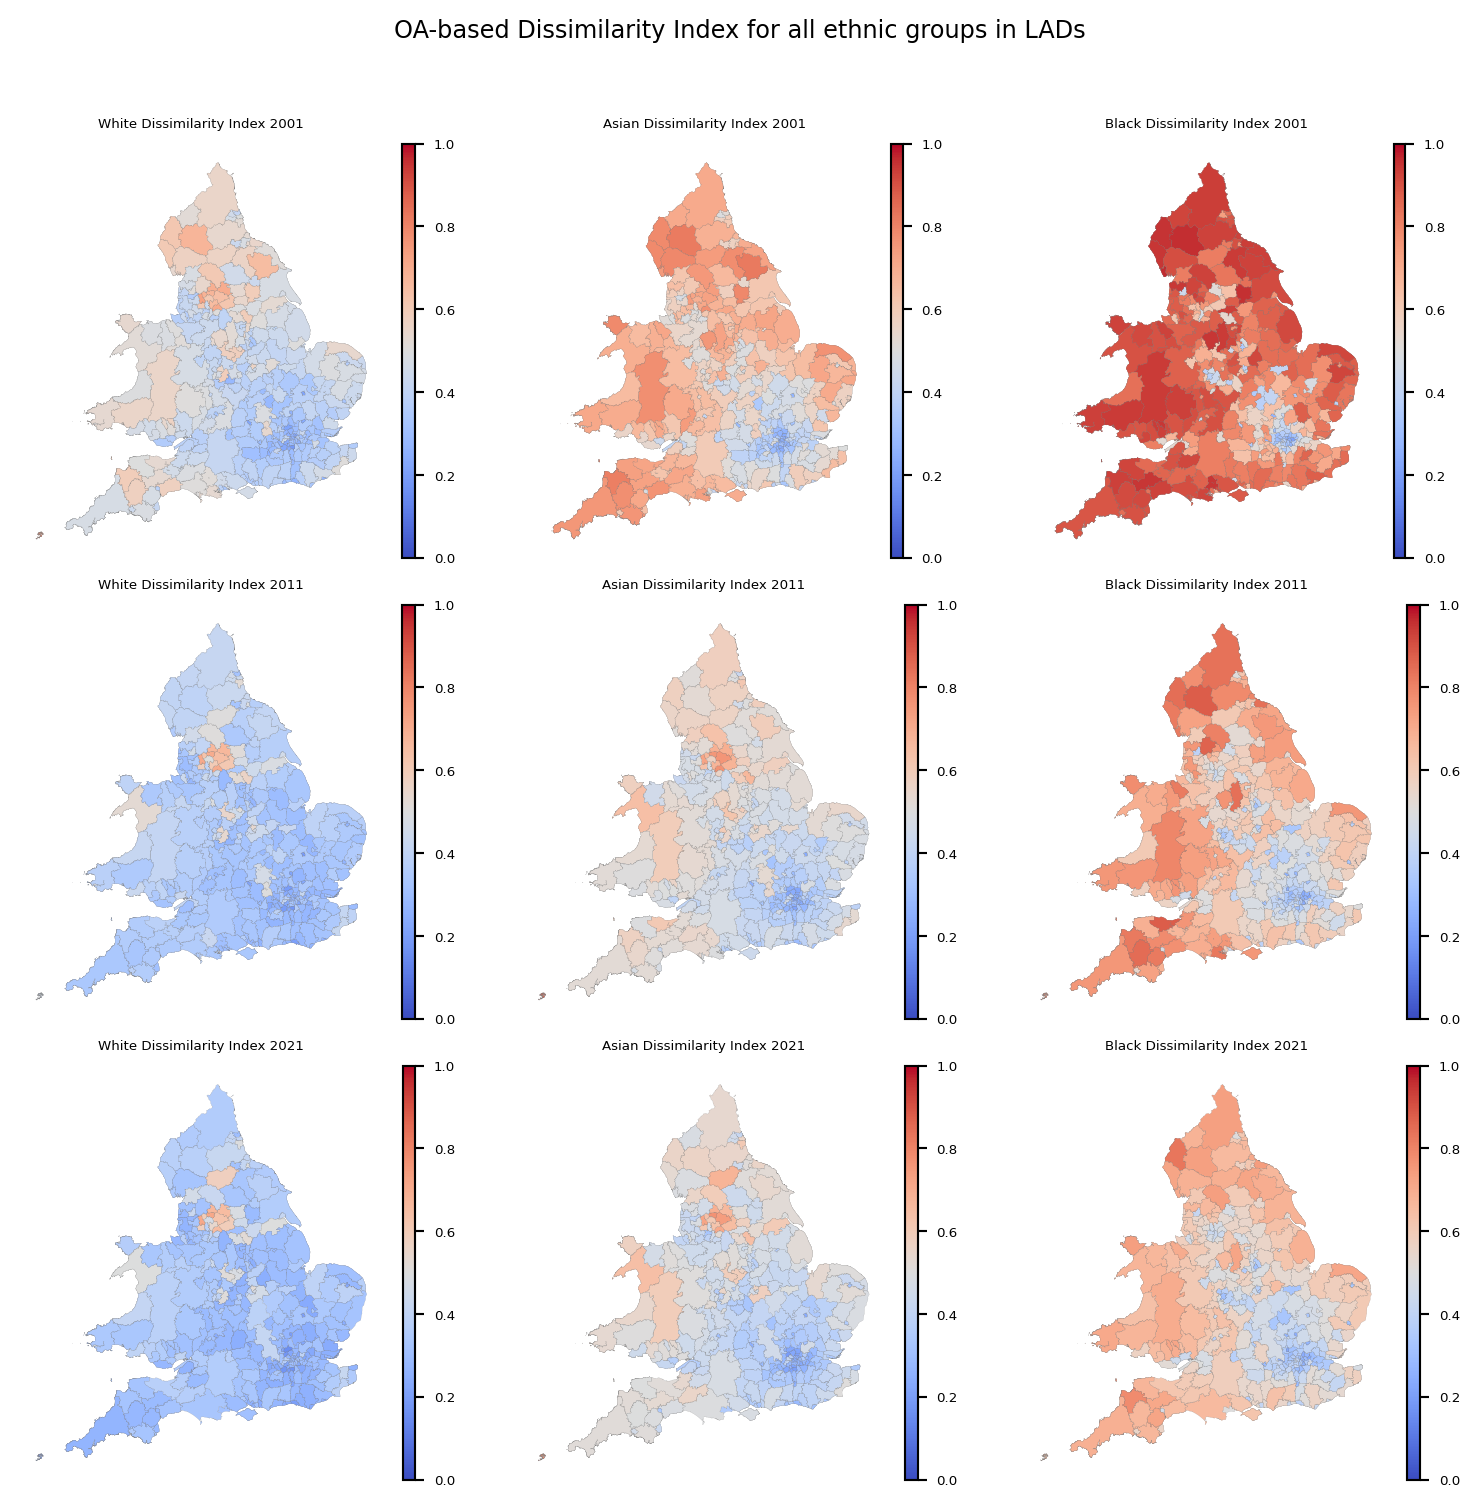

In [14]:
#| echo: false
#| label: fig-ladoadissmap
#| fig-cap: OA-based Dissimilarity Index for all ethnic groups in LADs

area = 'OA'
years = [2001, 2011, 2021]
map_data = pd.merge(LAD_dissimilarity_total, pd.concat([LAD_2001, LAD_2011, LAD_2021])[['LADCD', 'geometry']], on='LADCD')
map_data = gpd.GeoDataFrame(map_data, geometry='geometry')

# Reverse the colormap for the last column
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(8, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Variables and titles for the plots
variables = [
    (f'{area}_white', 0, 1, 'White Dissimilarity Index', 'coolwarm'),
    (f'{area}_asian', 0, 1, 'Asian Dissimilarity Index', 'coolwarm'),
    (f'{area}_black', 0, 1, 'Black Dissimilarity Index', 'coolwarm'),
]

# Loop through years and variables to plot the maps
for j, year in enumerate(years):
    for i, (variable, min_val, max_val, title, cmap) in enumerate(variables):
        # Filter data for the given year
        data_year = map_data[map_data['year'] == year]

        # Determine the correct subplot index
        ax_index = j * 3 + i
        
        # Plot the variable
        ax = axes[ax_index]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=0.1)
        data_year.plot(column=variable, cmap=cmap, linewidth=0.05, ax=ax, edgecolor='0.5',
                       vmin=min_val, vmax=max_val, legend=False)
        
        # Manually create the colorbar
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.tick_params(labelsize=5)

        ax.set_title(f'{title} {year}', fontsize=5)
        ax.axis('off')

fig.suptitle(f'{area}-based Dissimilarity Index for all ethnic groups in LADs', fontsize=9, y=0.97)

# Adjust layout
plt.subplots_adjust(hspace=0)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Simpson Index 
<p style="text-align: justify;" >

- A measure of ethnic concentration

- Score between 0 and 1

- Expresses the probability that two randomly selected individuals from the geographic area have the same ethnicity. 

This Average Local Simpson Index is calculated using the following formula: 

$$ 
S = {\sum_{i} (\frac{N_i} {N_{\text{Area}}} {\sum_{X} (P_i^X)^2})}
$$

Calculated for each $sub\_area_i$ as $S_i = {\sum_{X} (P_i^X)^2}$. The lower $S_i$, the more ethnically diverse is the $sub\_area_i$. The maximal value is achieved when the district is populated exclusively by one ethnic group. To calculate this index, only White British, Asians, and Blacks are considered, and “Other” ethnic groups is left outside. It has been done upon the consideration that individuals from this group are less likely to recognize each other as similar in terms of ethnic preferences. The Simpson Index is mathematically closely related to entropy, a measure of disorder which is also sometimes used in segregation studies to quantify the unequal distribution of ethnic groups between neighbourhoods or between the global and the local level.
[@Zuccotti2023]



In [15]:
#| include: false
country_simpson_total = pd.concat([country_simpson_2001, country_simpson_2011, country_simpson_2021], ignore_index=True)

In [16]:
#| include: false
simpson_visualisation = country_simpson_total.melt(id_vars=['year'], value_vars= country_simpson_total.columns[-5:], 
                           var_name='level', value_name='simpson_index')

### Simpson Index Line Chart at Country Level

In [17]:
#| echo: false
#| label: fig-simpcount
#| fig-cap: Simpson Index Line Chart at Country Level

traces = []
for level in simpson_visualisation['level'].unique():
    trace = go.Scatter(
        x= simpson_visualisation[simpson_visualisation['level'] == level]['year'],
        y= simpson_visualisation[simpson_visualisation['level'] == level]['simpson_index'],
        mode='lines+markers',
        name=level
    )
    traces.append(trace)

layout = go.Layout(title_text="Simpson Index Line Chart at Country Level",
                    title_x=0.5,
                    title_font=dict(size=16),
                    xaxis=dict(title='Year', tickvals=simpson_visualisation['year'].unique()),
                    yaxis=dict(title='Simpson Index'),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5),
                    hovermode='closest',
                    showlegend=True,
                    height = 400,
                    width = 600
)


fig = go.Figure(data=traces, layout=layout)

# fig.show()
pyo.iplot(fig)

## Simpson Index at LAD Level
<p style="text-align: justify;" >
In this part of the study, the Simpson index is calculated at LAD level. Therefore, OAs, LSOAs, and MSOAs were considered as the subareas of interest. The results are presented in @tbl-simplad. 
By sorting the table based on the lowest Simpson index, it is noticeable that the LADs included as part of London (LAD codes between E09000001 and E09000033) have the lowest Simpson index in England. This suggests that these areas can be considered less segregated.
</p>


In [18]:
#| include: false
# computing the difference columns
LAD_simpson_total = pd.concat([LAD_simpson_2001, LAD_simpson_2011, LAD_simpson_2021], ignore_index=True)
LAD_simpson_total['OA_LAD_diff']= LAD_simpson_total['OA']- LAD_simpson_total['LAD']
LAD_simpson_total['LSOA_LAD_diff']= LAD_simpson_total['LSOA']- LAD_simpson_total['LAD']
LAD_simpson_total['MSOA_LAD_diff']= LAD_simpson_total['MSOA']- LAD_simpson_total['LAD']

### Index Box-Plot based on different areas across the years

In [19]:
#| echo: false
#| label: fig-simpbox
#| fig-cap: Simpson Index Box-Plot based on different areas across the years
# Simpson Index Box-Plot based on different areas across the years
fig = make_subplots(rows=1, cols=4, subplot_titles=("OA", "LSOA", "MSOA", "LAD"))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

years= ["2001", "2011", "2021"]
box_colors = ['#636EFA','#EF553B','#00CC96','#AB63FA']
areas= ["OA", "LSOA", "MSOA", "LAD"]

for i, area  in enumerate(areas, start=1):
    for j, year in enumerate(years):
        show_legend = False if i != 1 else True 
        df = LAD_simpson_total[LAD_simpson_total['year'] == int(year)]
        hover_text = df['LADNM'] 
        fig.add_trace(go.Box(y=df[area], 
                                name=f'{year}', 
                                # boxpoints='all',
                                hovertext=hover_text, 
                                showlegend=show_legend, marker=dict(color=box_colors[j])), row=1, col=i)


fig.update_layout(title_text='Simpson Index Box-Plot based on different areas across the years',
                    title_x=0.5,
                    # title_y=0.95,
                    title_font=dict(size=16),
                    height=400,
                    width=800,
                    yaxis=dict(title='Simpson Index'),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5)
)
for i in range(1, 5):
    fig.update_yaxes(range=[0.24, 1.01], row=1, col=i)

# fig.show()
pyo.iplot(fig)

### Simpson Index Differences between LAD and other areas across the years

In [20]:
#| echo: false
#| label: fig-simpdiffbox
#| fig-cap: Simpson Index Differences between LAD and other areas across the years
# Simpson Index Differences between LAD and other areas across the years

fig = make_subplots(rows=1, cols=3, subplot_titles=("LAD_OA", "LAD_LSOA", "LAD_MSOA"))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)
    
years= ["2001", "2011", "2021"]
box_colors = ['#636EFA','#EF553B','#00CC96','#AB63FA']
areas= ["OA_LAD_diff", "LSOA_LAD_diff", "MSOA_LAD_diff"]

for i, area  in enumerate(areas, start=1):
    for j, year in enumerate(years):
        show_legend = False if i != 1 else True 
        df = LAD_simpson_total[LAD_simpson_total['year'] == int(year)]
        hover_text = df['LADNM']    # Replace 'LADNM' with the actual column name containing the names
        fig.add_trace(go.Box(y=df[area], 
                                name=f'{year}', 
                                # boxpoints='all',
                                hovertext=hover_text, 
                                showlegend=show_legend, marker=dict(color=box_colors[j])), row=1, col=i)
    
fig.update_layout(title_text='Simpson Index Differences between LAD and other areas across the years',
                    title_x=0.5,
                    title_font=dict(size=16),
                    height=400,
                    width=800,
                    yaxis=dict(title='Simpson Index Difference'),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5)
)
for i in range(1, 4):
    fig.update_yaxes(range=[-0.01, 0.28], row=1, col=i)

# fig.show()
pyo.iplot(fig)

### LADs' Simpson Index on Map of England

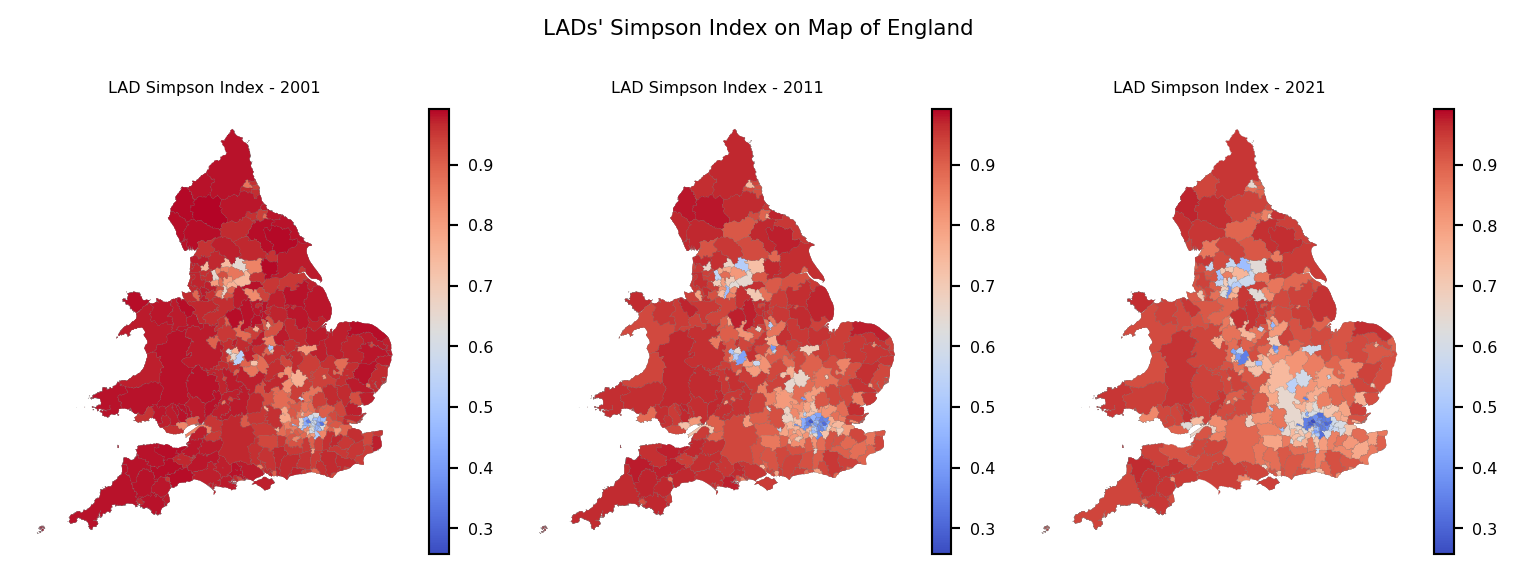

In [21]:
#| echo: false
#| label: fig-simpinxmap
#| fig-cap: LADs' Simpson Index on Map of England
# LADs' Simpson Index on Map of England

years = [2001, 2011, 2021]

LAD_simpson_min, LAD_simpson_max = LAD_simpson_total['LAD'].min(), LAD_simpson_total['LAD'].max()

# Merge the Simpson index data with geometries from different years
map_data = pd.merge(LAD_simpson_total, pd.concat([LAD_2001, LAD_2011, LAD_2021])[['LADCD', 'geometry']], on='LADCD')
map_data = gpd.GeoDataFrame(map_data, geometry='geometry')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

# Loop through years and columns to plot the maps
for ax, year in zip(axes, years):
    # Filter data for the given year
    data_year = map_data[map_data['year'] == year]

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    data_year.plot(column='LAD', cmap='coolwarm', linewidth=0.05, ax=ax, edgecolor='0.5',
                   vmin=LAD_simpson_min, vmax=LAD_simpson_max, legend=False)
    
    # Manually create the colorbar
    norm = plt.Normalize(vmin=LAD_simpson_min, vmax=LAD_simpson_max)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.ax.tick_params(labelsize=6)

    ax.set_title(f'LAD Simpson Index - {year}', fontsize=6)
    ax.axis('off')

fig.suptitle("LADs' Simpson Index on Map of England", fontsize=8, y=1)

# Adjust layout
plt.tight_layout()
plt.show()

### Difference of LAD-OA Simpson Indices on Map of England

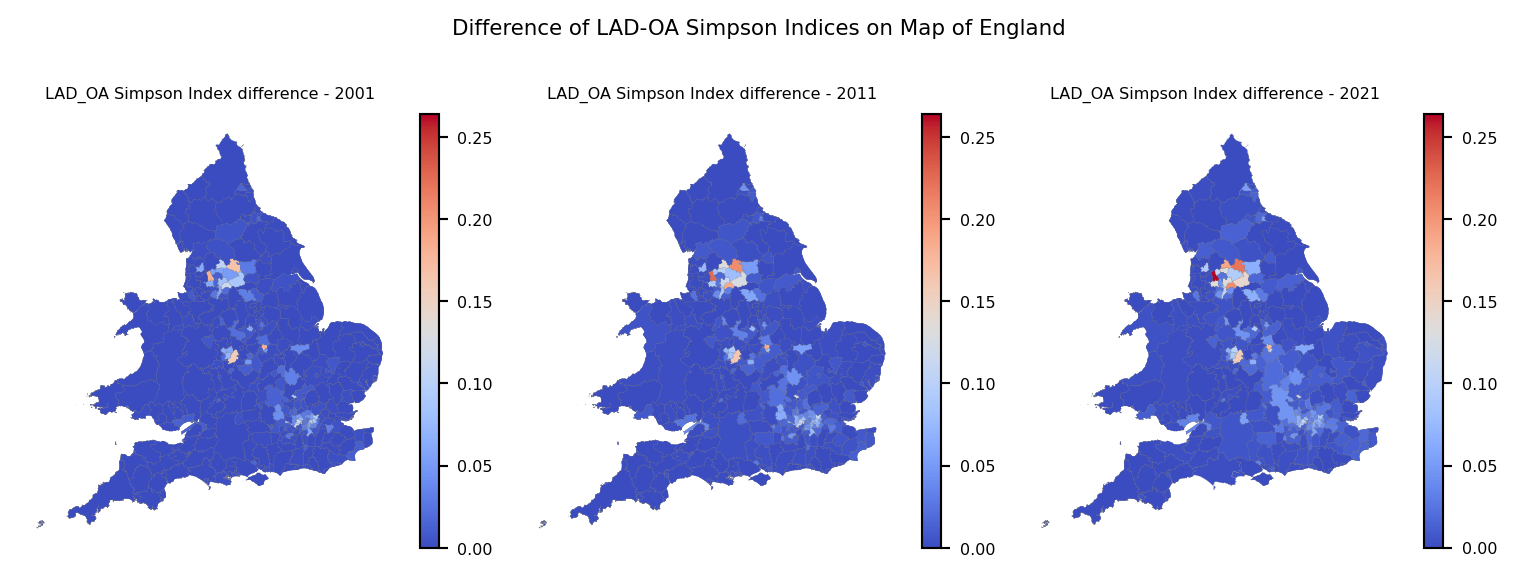

In [22]:
#| echo: false
#| label: fig-simpdiffmap
#| fig-cap: Difference of LAD-OA Simpson Indices on Map of England
# Difference of LAD-OA Simpson Indices on Map of England

years = [2001, 2011, 2021]

# Assuming LAD_simpson_total contains the Simpson index data
LAD_simpson_min, LAD_simpson_max = LAD_simpson_total['OA_LAD_diff'].min(), LAD_simpson_total['OA_LAD_diff'].max()

# Merge the Simpson index data with geometries from different years
map_data = pd.merge(LAD_simpson_total, pd.concat([LAD_2001, LAD_2011, LAD_2021])[['LADCD', 'geometry']], on='LADCD')
map_data = gpd.GeoDataFrame(map_data, geometry='geometry')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 3))

# Loop through years and columns to plot the maps
for ax, year in zip(axes, years):
    # Filter data for the given year
    data_year = map_data[map_data['year'] == year]

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    data_year.plot(column='OA_LAD_diff', cmap='coolwarm', linewidth=0.05, ax=ax, edgecolor='0.5',
                   vmin=LAD_simpson_min, vmax=LAD_simpson_max, legend=False, cax=cax)
   
    # Manually create the colorbar
    norm = plt.Normalize(vmin=LAD_simpson_min, vmax=LAD_simpson_max)
    cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
    cbar.ax.tick_params(labelsize=6)

    ax.set_title(f'LAD_OA Simpson Index difference - {year}', fontsize=6)
    ax.axis('off')

fig.suptitle('Difference of LAD-OA Simpson Indices on Map of England', fontsize=8, y=1)

# Adjust layout
plt.tight_layout()
plt.show()

## Moran's I Index

In [23]:
#| include: false
# Calculating Moran's I Iindex for country level, considering LAD as sub area
Moran_2001 = moran(ethnicity_2001.groupby(['LAD01CD'])[['white' , 'asian' , 'black','other']].sum()[['white' , 'asian' , 'black','other']],LAD_borders_2001)

Moran_2011 = moran(ethnicity_2011.groupby(['LAD11CD'])[['white' , 'asian' , 'black','other']].sum()[['white' , 'asian' , 'black','other']],LAD_borders_2011)

Moran_2021 = moran(ethnicity_2021.groupby(['LAD21CD'])[['white' , 'asian' , 'black','other']].sum()[['white' , 'asian' , 'black','other']],LAD_borders_2021)


In [24]:
#| include: false
# Country Level Moran's I IIndex in 3 years
Moran_2001['year'] = 2001
Moran_2011['year'] = 2011
Moran_2021['year'] = 2021
country_moran_total = pd.DataFrame([Moran_2001, Moran_2011, Moran_2021])
column_order= ["year", "white", "asian", "black", "other"]
country_moran_total = country_moran_total[column_order]

country_moran_total = country_moran_total.rename(columns={col: f'{col}_moran' for col in ["white", "asian", "black", "other"]})

### Moran's I Is IIndex Variation Across the Year

In [25]:
#| echo: false
#| label: fig-morcount
#| fig-cap: Moran's I Is IIndex Variation Across the Year
# Moran's I Variation Across the Years

colors = ['darkgray', 'orange', 'black', 'green']
ethnicity = ['white_moran', 'asian_moran', 'black_moran', 'other_moran']
fig = make_subplots(rows=1, cols=2, shared_xaxes=True, subplot_titles=("Bar Chart", "Line Chart"))

bar_traces = []
for i, ethnic in enumerate(ethnicity):
    trace = go.Bar(
        x=country_moran_total['year'],
        y=country_moran_total[ethnic],
        name=ethnic,
        marker=dict(color=colors[i])
    )
    bar_traces.append(trace)

line_traces = []
for i, ethnic in enumerate(ethnicity):
    trace = go.Scatter(
        x=country_moran_total['year'],
        y=country_moran_total[ethnic],
        name=ethnic,
        mode='lines+markers',
        line=dict(color=colors[i], width=2)
    )
    line_traces.append(trace)

for trace in bar_traces:
    fig.add_trace(trace, row=1, col=1)

for trace in line_traces:
    fig.add_trace(trace, row=1, col=2)

fig.update_layout(title_text= "Moran's I Index Variation Across the Year",
                    title_font=dict(size=16),
                    title_x=0.5,
                    title_y=0.97,
                    yaxis=dict(title="moran's I Index"),
                    width=750,
                    height=400,
                    legend=dict(orientation="h",
                        yanchor="top",
                        y=1.31,
                        xanchor="center",
                        x=0.5,
                        traceorder='normal')
)
for i in range (1,3):
    fig.update_xaxes(tickvals=country_moran_total['year'], row=1, col=i)


pyo.iplot(fig)

## Moran's I at LAD level
<p style="text-align: justify;" >

</p>

<p style="text-align: justify;" >
In this part of the study, Moran’s I index is calculated for each LAD. For LADs, Moran’s I index is computable for OA, LSOA and MSOA levels. 
The results are presented in @tbl-morcount. The NaN value for each subarea's Moran’s I indicates subareas with a population count of zero for a specific ethnicity.
</p>

In [26]:
#| Include: false
# Moran's I Variation Across the Years
LAD_moran_total = pd.concat([LAD_moran_2001, LAD_moran_2011, LAD_moran_2021], ignore_index= True)
LAD_moran_total= LAD_moran_total.rename(columns={col:f'{col}_mor' for col in ['OA_white', 'LSOA_white', 'MSOA_white',
       'OA_asian', 'LSOA_asian', 'MSOA_asian', 'OA_black', 'LSOA_black',
       'MSOA_black', 'OA_other', 'LSOA_other', 'MSOA_other']})

In [27]:
#| include: false
pd.concat([LAD_moran_total[LAD_moran_total['year']==2001].sort_values('LSOA_white_mor',ascending= False).head(5),
LAD_moran_total[LAD_moran_total['year']==2011].sort_values('LSOA_white_mor',ascending= False).head(5),
LAD_moran_total[LAD_moran_total['year']==2021].sort_values('LSOA_white_mor',ascending= False).head(5)]).reset_index(drop= True)

,year,LADNM,LADCD,LAD_population,white_frac,asian_frac,black_frac,other_frac,OA_white_mor,LSOA_white_mor,MSOA_white_mor,OA_asian_mor,LSOA_asian_mor,MSOA_asian_mor,OA_black_mor,LSOA_black_mor,MSOA_black_mor,OA_other_mor,LSOA_other_mor,MSOA_other_mor
0,2001,Birmingham,E08000025,977057,0.704,0.207,0.061,0.029,0.926,0.920,0.793,0.892,0.878,0.710,0.761,0.835,0.774,0.363,0.557,0.545
1,2001,Croydon,E09000008,330688,0.701,0.128,0.133,0.037,0.869,0.919,0.853,0.740,0.801,0.640,0.832,0.907,0.894,0.253,0.488,0.677
2,2001,Redbridge,E09000026,238511,0.636,0.265,0.076,0.024,0.881,0.850,0.648,0.850,0.819,0.633,0.577,0.641,0.551,0.104,0.144,0.307
3,2001,Enfield,E09000010,273616,0.771,0.094,0.105,0.030,0.785,0.849,0.676,0.578,0.717,0.522,0.780,0.857,0.696,0.222,0.461,0.490
4,2001,Ealing,E09000009,300886,0.587,0.289,0.088,0.036,0.835,0.846,0.636,0.860,0.876,0.627,0.478,0.364,0.135,0.204,0.347,0.216
5,2011,Birmingham,E08000025,1073045,0.579,0.266,0.090,0.065,0.921,0.919,0.820,0.881,0.874,0.727,0.718,0.750,0.670,0.522,0.676,0.613
6,2011,Croydon,E09000008,363378,0.551,0.164,0.202,0.083,0.870,0.902,0.828,0.737,0.753,0.539,0.816,0.882,0.852,0.431,0.640,0.708
7,2011,Derby,E06000015,248752,0.803,0.125,0.029,0.043,0.884,0.866,0.611,0.851,0.819,0.562,0.543,0.787,0.666,0.520,0.738,0.594
8,2011,Enfield,E09000010,312466,0.610,0.112,0.172,0.106,0.831,0.861,0.718,0.480,0.677,0.479,0.835,0.870,0.739,0.407,0.592,0.585
9,2011,Hounslow,E09000018,253957,0.514,0.344,0.066,0.076,0.852,0.844,0.793,0.860,0.863,0.819,0.285,0.175,-0.002,0.159,0.211,0.334


In [28]:
#| echo: false
#| label: fig-mornbox
#| fig-cap: OA-based Moran's I in LADs for Ethnicities across the years
# OA-based Moran's I in LADs for Ethnicities across the years

fig = make_subplots(rows=1, cols=4, subplot_titles=("White", "Asian", "Black", "Other"))
for annotation in fig['layout']['annotations']:
    annotation['font'] = dict(size=12)

years= ["2001", "2011", "2021"]
box_colors = ['#636EFA','#EF553B','#00CC96','#AB63FA']
ethnicities= ["OA_white_mor", "OA_asian_mor", "OA_black_mor", "OA_other_mor"]

for i, ethnicity  in enumerate(ethnicities, start=1):
    for j, year in enumerate(years):
        show_legend = False if i != 1 else True 
        df = LAD_moran_total[LAD_moran_total['year'] == int(year)]
        hover_text = df['LADNM'] 
        fig.add_trace(go.Box(y=df[ethnicity], 
                                name=f'{year}', 
                                # boxpoints='all',
                                hovertext=hover_text, 
                                showlegend=show_legend, marker=dict(color=box_colors[j])), row=1, col=i)


fig.update_layout(title_text= "OA-based Moran's I in LADs for Ethnicities across the years",
                    title_x=0.5,
                    # title_y=0.95,
                    title_font=dict(size=16),
                    height=400,
                    width=800,
                    yaxis=dict(title="Moran's I Index"),
                    legend=dict(orientation="h",
                                yanchor="top",
                                y=1.2,
                                xanchor="center",
                                x=0.5)
)
for i in range(1, 5):
    fig.update_yaxes(range=[-0.3, 1.01], row=1, col=i)

# fig.show()
pyo.iplot(fig)

In [29]:
#| include: false
# creating a complete df for country level
country_total= country_simpson_total.merge(country_moran_total, on = 'year', how = 'left')

country_total.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson', 'country': 'country_simpson',
                                        'white':'white_moran' , 'asian':'asian_moran' ,'black':'black_moran' , 'other':'other_moran'},
                                        inplace = True)
country_total= country_total.merge(country_dissimilarity_total[['year', 'OA_white', 'LSOA_white','MSOA_white', 'LAD_white',
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian', 'LAD_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 'LAD_black',
                                                                 'OA_other', 'LSOA_other', 'MSOA_other', 'LAD_other']], on= 'year', how= 'left')
country_total.rename(columns={'OA_white':'OA_white_diss', 'LSOA_white':'LSOA_white_diss', 'MSOA_white':'MSOA_white_diss', 'LAD_white':'LAD_white_diss',
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian':'MSOA_asian_diss', 'LAD_asian':'LAD_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black':'MSOA_black_diss', 'LAD_black':'LAD_black_diss',
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other':'MSOA_other_diss', 'LAD_other':'LAD_other_diss'}, inplace = True)

In [30]:
#| include: false
LAD_visualisation_2001= LAD_2001.merge(LAD_simpson_total[LAD_simpson_total.year==2001][['LADCD','OA','LSOA','MSOA','LAD','OA_LAD_diff',
                              'LSOA_LAD_diff', 'MSOA_LAD_diff']], on = 'LADCD', how = 'left')

LAD_visualisation_2001.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson'},
                                        inplace = True)
LAD_visualisation_2001= LAD_visualisation_2001.merge(LAD_dissimilarity_total[LAD_dissimilarity_total.year==2001][['LADCD', 'OA_white', 'LSOA_white','MSOA_white', 
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 
                                                                 'OA_other', 'LSOA_other', 'MSOA_other']], on= 'LADCD', how= 'left')
LAD_visualisation_2001.rename(columns={'OA_white':'OA_white_diss' , 'LSOA_white': 'LSOA_white_diss','MSOA_white': 'MSOA_white_diss', 
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian': 'MSOA_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black': 'MSOA_black_diss', 
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other': 'MSOA_other_diss'}, inplace = True)
LAD_visualisation_2001= LAD_visualisation_2001.merge(LAD_moran_total[LAD_moran_total.year==2001][['LADCD', 
                                                'OA_white_mor', 'LSOA_white_mor', 'MSOA_white_mor', 
                                                'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor',
                                                'OA_black_mor', 'LSOA_black_mor', 'MSOA_black_mor', 
                                                'OA_other_mor', 'LSOA_other_mor', 'MSOA_other_mor']],  on= 'LADCD', how= 'left')

In [31]:
#| include: false
LAD_visualisation_2011= LAD_2011.merge(LAD_simpson_total[LAD_simpson_total.year==2011][['LADCD','OA','LSOA','MSOA','LAD','OA_LAD_diff',
                              'LSOA_LAD_diff', 'MSOA_LAD_diff']], on = 'LADCD', how = 'left')

LAD_visualisation_2011.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson'},
                                        inplace = True)
LAD_visualisation_2011= LAD_visualisation_2011.merge(LAD_dissimilarity_total[LAD_dissimilarity_total.year==2011][['LADCD', 'OA_white', 'LSOA_white','MSOA_white', 
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 
                                                                 'OA_other', 'LSOA_other', 'MSOA_other']], on= 'LADCD', how= 'left')
LAD_visualisation_2011.rename(columns={'OA_white':'OA_white_diss' , 'LSOA_white': 'LSOA_white_diss','MSOA_white': 'MSOA_white_diss', 
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian': 'MSOA_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black': 'MSOA_black_diss', 
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other': 'MSOA_other_diss'}, inplace = True)
LAD_visualisation_2011= LAD_visualisation_2011.merge(LAD_moran_total[LAD_moran_total.year==2011][['LADCD', 
                                                'OA_white_mor', 'LSOA_white_mor', 'MSOA_white_mor', 
                                                'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor',
                                                'OA_black_mor', 'LSOA_black_mor', 'MSOA_black_mor', 
                                                'OA_other_mor', 'LSOA_other_mor', 'MSOA_other_mor']],  on= 'LADCD', how= 'left')


In [32]:
#| include: false
LAD_visualisation_2021= LAD_2021.merge(LAD_simpson_total[LAD_simpson_total.year==2021][['LADCD','OA','LSOA','MSOA','LAD','OA_LAD_diff',
                              'LSOA_LAD_diff', 'MSOA_LAD_diff']], on = 'LADCD', how = 'left')

LAD_visualisation_2021.rename(columns={'OA':'OA_simpson' , 'LSOA': 'LSOA_simpson','MSOA': 'MSOA_simpson', 'LAD': 'LAD_simpson'},
                                        inplace = True)
LAD_visualisation_2021= LAD_visualisation_2021.merge(LAD_dissimilarity_total[LAD_dissimilarity_total.year==2021][['LADCD', 'OA_white', 'LSOA_white','MSOA_white', 
                                                                 'OA_asian', 'LSOA_asian', 'MSOA_asian',
                                                                 'OA_black', 'LSOA_black', 'MSOA_black', 
                                                                 'OA_other', 'LSOA_other', 'MSOA_other']], on= 'LADCD', how= 'left')
LAD_visualisation_2021.rename(columns={'OA_white':'OA_white_diss' , 'LSOA_white': 'LSOA_white_diss','MSOA_white': 'MSOA_white_diss', 
                              'OA_asian':'OA_asian_diss', 'LSOA_asian':'LSOA_asian_diss', 'MSOA_asian': 'MSOA_asian_diss',
                              'OA_black':'OA_black_diss', 'LSOA_black':'LSOA_black_diss', 'MSOA_black': 'MSOA_black_diss', 
                              'OA_other':'OA_other_diss', 'LSOA_other':'LSOA_other_diss', 'MSOA_other': 'MSOA_other_diss'}, inplace = True)
LAD_visualisation_2021= LAD_visualisation_2021.merge(LAD_moran_total[LAD_moran_total.year==2021][['LADCD', 
                                                'OA_white_mor', 'LSOA_white_mor', 'MSOA_white_mor', 
                                                'OA_asian_mor', 'LSOA_asian_mor', 'MSOA_asian_mor',
                                                'OA_black_mor', 'LSOA_black_mor', 'MSOA_black_mor', 
                                                'OA_other_mor', 'LSOA_other_mor', 'MSOA_other_mor']],  on= 'LADCD', how= 'left')

In [33]:
#| include: false
LAD_total = pd.concat([LAD_visualisation_2001,LAD_visualisation_2011,LAD_visualisation_2021])
LAD_total= LAD_total.set_geometry('geometry')

### OA-based Moran's I in LADs on Map of England

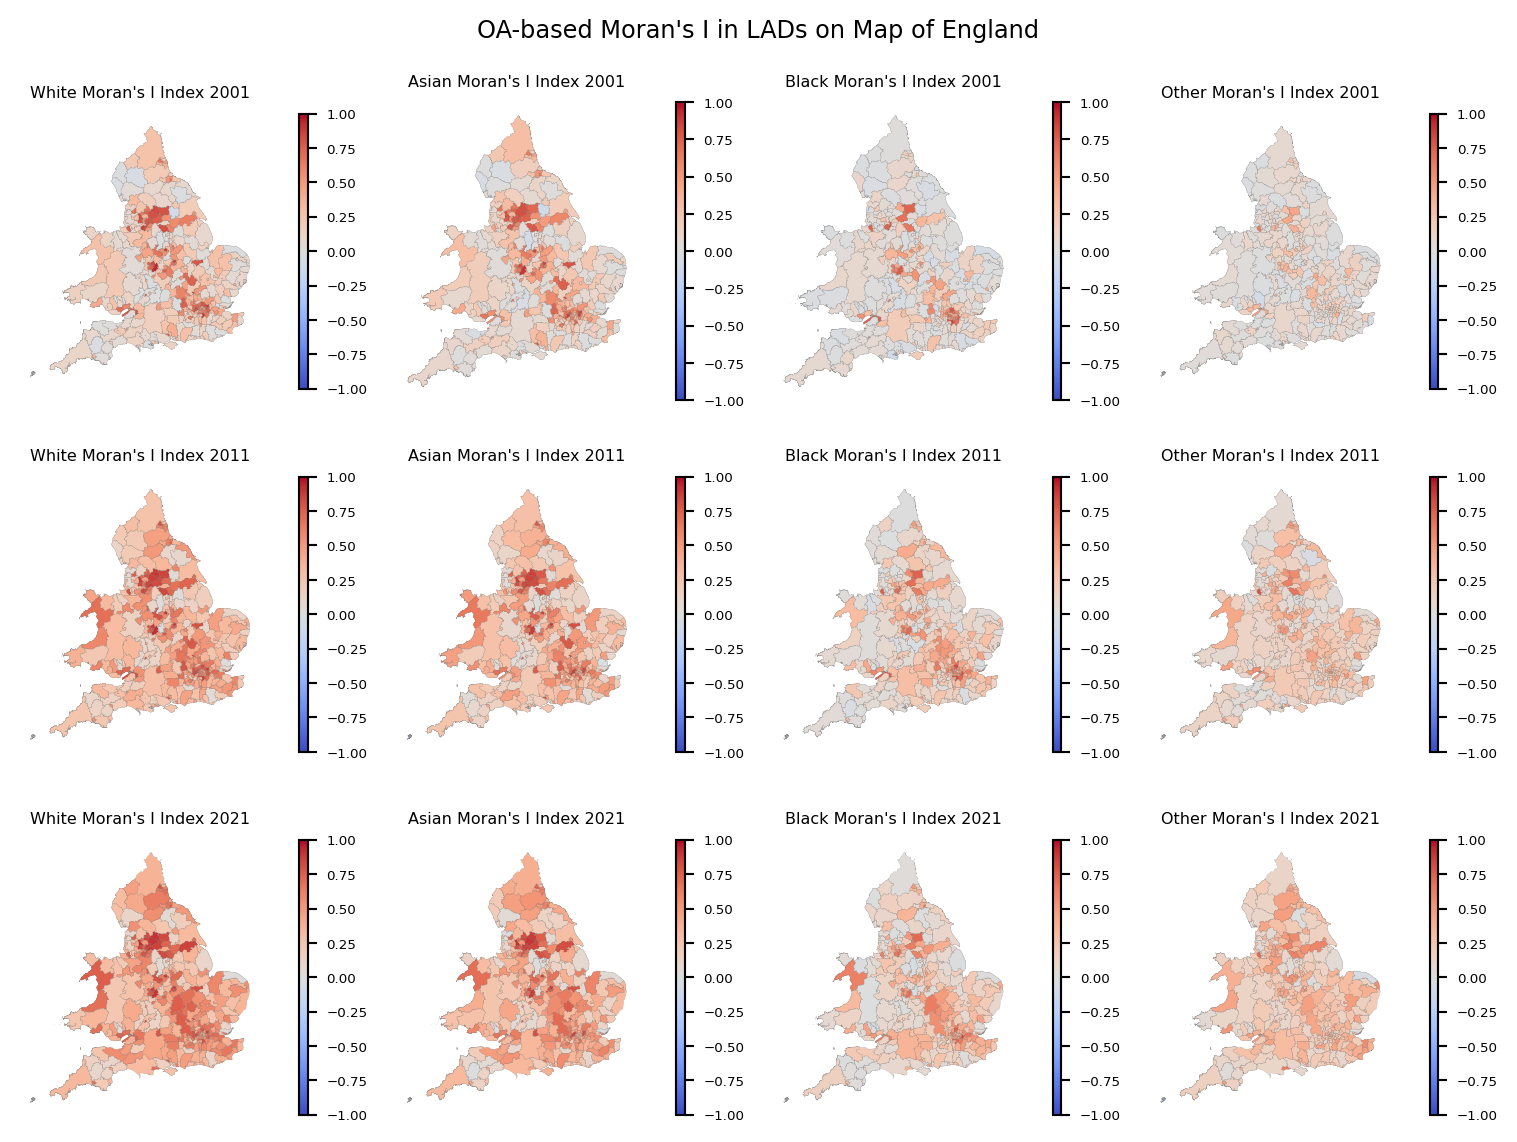

In [34]:
#| echo: false
#| label: fig-moranonxmap
#| fig-cap: OA-based Moran's I in LADs on Map of England

map_data = pd.merge(LAD_moran_total, LAD_total[['LADCD', 'geometry']], on='LADCD')
map_data = gpd.GeoDataFrame(map_data, geometry='geometry')

years = [2001, 2011, 2021]

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8, 8))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Variables and titles for the plots
variables = [
    ('OA_white_mor', -1, 1, 'White Moran\'s I Index', 'coolwarm'),
    ('OA_asian_mor', -1, 1, 'Asian Moran\'s I Index', 'coolwarm'),
    ('OA_black_mor', -1, 1, 'Black Moran\'s I Index', 'coolwarm'),
    ('OA_other_mor', -1, 1, 'Other Moran\'s I Index', 'coolwarm'),
]

# Loop through years and variables to plot the maps
for j, year in enumerate(years):
    for i, (variable, min_val, max_val, title, cmap) in enumerate(variables):
        # Filter data for the given year
        data_year = map_data[map_data['year'] == year]

        # Determine the correct subplot index
        ax_index = j * 4 + i
        
        # Plot the variable
        ax = axes[ax_index]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3.5%", pad=0.2)
        data_year.plot(column=variable, cmap=cmap, linewidth=0.05, ax=ax, edgecolor='0.5',
                       vmin=min_val, vmax=max_val, legend=False)
    
        # Manually create the colorbar
        norm = plt.Normalize(vmin=min_val, vmax=max_val)
        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.tick_params(labelsize=5)

        ax.set_title(f'{title} {year}', fontsize=6)
        ax.axis('off')

fig.suptitle('OA-based Moran\'s I in LADs on Map of England', fontsize=9, y=0.85)

# Adjust layout
plt.subplots_adjust(hspace=-0.5)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Simpson Index</span>

# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Moran's I Index</span>


# <span style="text-align: center; justify-content: center; font-size: 1.4em;" >Detailed Examination of Segregation in Selected English Cities</span>
